In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import koreanize_matplotlib

In [5]:
df = pd.read_csv('../datasets/KOPIS/performance_cleaned.csv')

In [11]:
facility_df = pd.read_csv('../datasets/KOPIS/facility_df.csv')

In [67]:
price_stats_df = pd.read_csv('../datasets/KOPIS/price_stats.csv')

In [13]:
df.columns

Index(['공연ID', '공연명', '공연시작일', '공연종료일', '공연시설명', '출연진', '제작진', '런타임', '관람연령',
       '제작사', '기획사', '주최', '주관', '티켓가격', '포스터URL', '줄거리', '공연지역', '공연장르명',
       '오픈런', '내한여부', '아동공연여부', '대학로공연여부', '축제여부', '뮤지컬라이센스', '뮤지컬창작', '최종수정일',
       '공연상태', '공연시설ID', '공연시간', '장르(통계)', '상연횟수', '공연명(통계)', '공연시설명(통계)',
       '공연시작일(통계)', '공연종료일(통계)', '연도(통계)', '월(통계)', '장르코드(통계)', '티켓가격_list',
       '최소가격', '최대가격', '공연시작연도'],
      dtype='object')

In [10]:
# 공연시작연도 칼럼 만들기

df['공연시작연도'] = pd.to_datetime(
    df['공연시작일'], errors='coerce'
).dt.year

# 2014년 이전 공연은 모두 2014년으로 치환
df.loc[df['공연시작연도'] < 2014, '공연시작연도'] = 2014

In [12]:
facility_df.columns

Index(['공연시설ID', '공연시설명', '공연장수', '시설특성', '개관연도', '객석수', '전화번호', '홈페이지', '주소',
       '위도', '경도', '레스토랑여부', '카페여부', '편의점여부', '놀이방여부', '수유실여부', '장애시설_주차장',
       '장애시설_화장실', '장애시설_경사로', '장애시설_엘리베이터', '주차시설여부', 'mt13s', 'returncode',
       'errmsg', 'responsetime', '시군구', '시도'],
      dtype='object')

In [14]:
# 공연 + 시설 merge
merged = df.merge(
    facility_df[['공연시설ID', '객석수']],
    on='공연시설ID',
    how='left'
)

In [15]:
# 1. 규모 분류 (객석수)
merged['규모(객석)'] = merged['객석수'].apply(
    lambda x: (
        "대규모" if pd.notna(x) and x >= 1000
        else "중규모" if pd.notna(x) and x >= 500
        else "소규모" if pd.notna(x)
        else "기타"
    )
)

In [23]:
merged["규모(객석)"].value_counts()

# 소규모 공연이 압도적으로 많음
# 중규모는 오히려 대규모보다 적음 -> 공연 시장 허리가 비어 있음
# 공연 생태계가 소규모 <-> 대규모 양극화 구조

규모(객석)
소규모    21039
대규모     8655
중규모     5718
기타         3
Name: count, dtype: int64

In [24]:
# 2. 뮤지컬 속성 분류
def categorize_musical_by_flags(row):
    if row.get("뮤지컬라이센스") == "Y" or row.get("내한여부") == "Y":
        return "대형뮤지컬"
    elif row.get("뮤지컬창작") == "Y":
        return "창작뮤지컬"
    elif row.get("대학로공연여부") == "Y":
        return "대학로뮤지컬"
    else:
        return "기타뮤지컬"

merged["뮤지컬_속성구분"] = merged.apply(categorize_musical_by_flags, axis=1)

In [25]:
merged["뮤지컬_속성구분"].value_counts()

뮤지컬_속성구분
기타뮤지컬     21789
대학로뮤지컬     9468
창작뮤지컬      2877
대형뮤지컬      1281
Name: count, dtype: int64

In [51]:
merged = merged.merge(
    facility_df[['공연시설ID', '시도', '시군구', '위도', '경도']],
    on='공연시설ID',
    how='left'
)

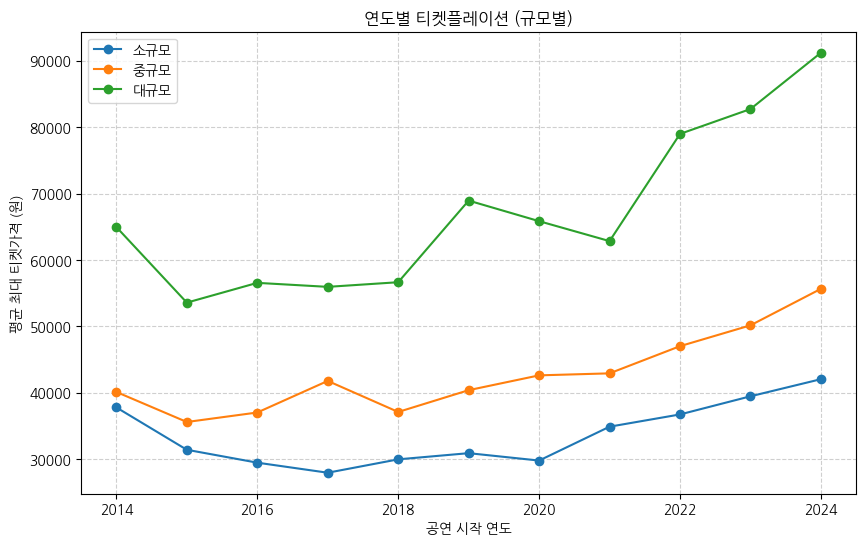

In [85]:
# 객석 규모별 티켓플레이션 곡선

pivot = (
    merged.dropna(subset=["공연시작연도", "최대가격", "규모(객석)"])
    .groupby(["공연시작연도", "규모(객석)"])["최대가격"]
    .mean()
    .reset_index()
    .pivot(index="공연시작연도", columns="규모(객석)", values="최대가격")
)

plt.figure(figsize=(10, 6))
for col in ["소규모","중규모","대규모"]:
    if col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=col)
    

plt.title("연도별 티켓플레이션 (규모별)")
plt.xlabel("공연 시작 연도")
plt.ylabel("평균 최대 티켓가격 (원)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [58]:
# 시군구별 공연 규모 카운트 집계
counts = (
    merged.groupby(["시도","시군구","규모(객석)"])["공연ID"]
          .count()
          .reset_index(name="공연수")
)

pivot = counts.pivot_table(
    index=["시도","시군구"],
    columns="규모(객석)",
    values="공연수",
    fill_value=0
).reset_index()

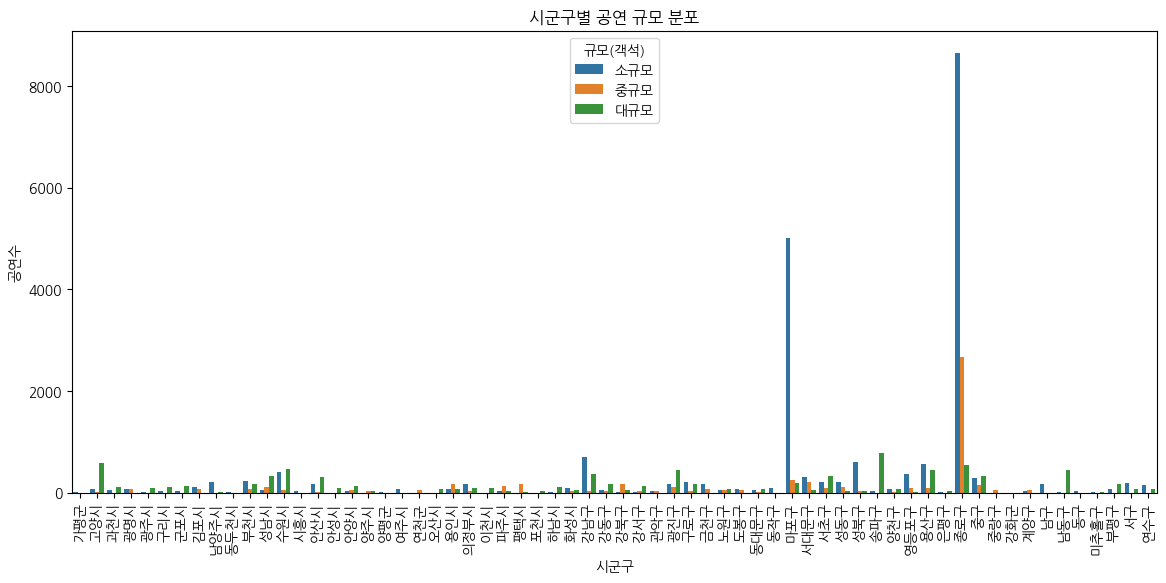

In [59]:
# 시군구별 공연 규모 분포

plt.figure(figsize=(14,6))
sns.barplot(data=counts, x="시군구", y="공연수", hue="규모(객석)", ci=None)
plt.xticks(rotation=90)
plt.title("시군구별 공연 규모 분포")
plt.show()

In [65]:
# 시도별로 중규모 개수 top3 추출
top3_by_sido = (
    pivot.sort_values(["시도", "중규모"], ascending=[True, False])
         .groupby("시도")
         .head(3)
         .reset_index(drop=True)
)

top3_by_sido

규모(객석),시도,시군구,대규모,소규모,중규모,총합,중규모비율
0,경기도,용인시,80.0,75.0,172.0,327.0,0.525994
1,경기도,평택시,8.0,4.0,167.0,179.0,0.932961
2,경기도,파주시,25.0,37.0,128.0,190.0,0.673684
3,서울특별시,종로구,552.0,8660.0,2680.0,11892.0,0.225362
4,서울특별시,마포구,195.0,5021.0,245.0,5461.0,0.044864
5,서울특별시,중구,598.0,512.0,223.0,1333.0,0.167292
6,인천광역시,중구,43.0,63.0,72.0,178.0,0.404494
7,인천광역시,계양구,1.0,43.0,56.0,100.0,0.560000
8,인천광역시,부평구,180.0,64.0,2.0,246.0,0.008130


In [66]:
import plotly.express as px

# 1. 시군구별 위도/경도 평균 붙이기
loc_info = (
    facility_df.groupby(["시도","시군구"])[["위도","경도"]]
               .mean()
               .reset_index()
)

# 2. top3_by_sido에 좌표 merge
top3_with_loc = top3_by_sido.merge(loc_info, on=["시도","시군구"], how="left")

# 3. 지도 시각화
fig = px.scatter_mapbox(
    top3_with_loc,
    lat="위도", lon="경도",
    size="중규모",                 # 버블 크기 = 중규모 공연 수
    color="시도",                 # 색깔 = 시도
    hover_name="시군구",          # 마우스오버 시군구명
    hover_data={"중규모": True, "시도": True, "위도": False, "경도": False},
    zoom=8,
    height=600,
)

fig.update_layout(
    mapbox_style="carto-positron",
    title="시도별 중규모 공연 Top3 지역 (총 9곳)"
)

fig.show()


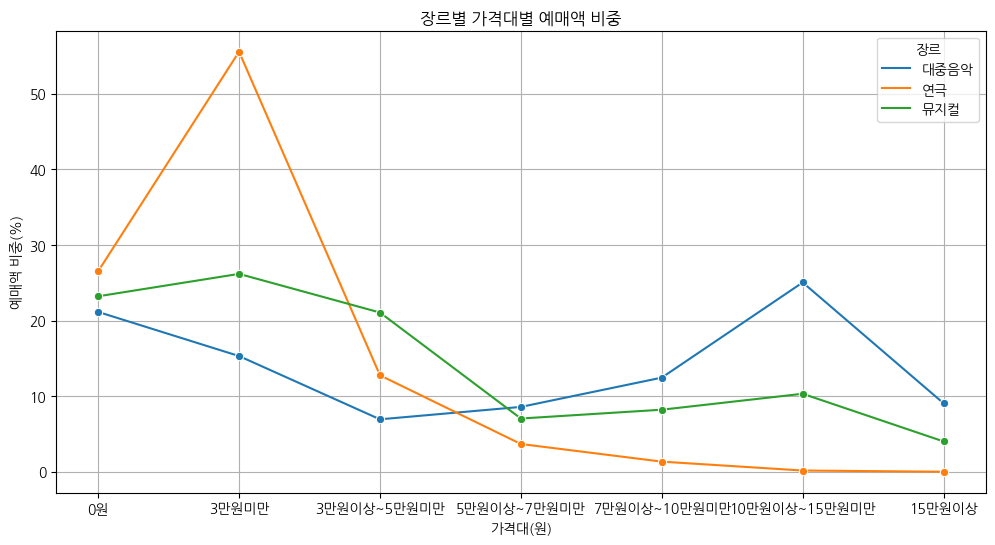

In [79]:
# 장르별 가격대 예매액(매출) 비중 평균
# 매출 비중 -> 고가 티켓 위 주 공연이 유리
genre_price = price_stats_df.groupby(["장르","가격대"])["예매액비중"].mean().reset_index()

order = ["0원","3만원미만","3만원이상~5만원미만","5만원이상~7만원미만",
         "7만원이상~10만원미만","10만원이상~15만원미만","15만원이상"]

genre_price["가격대"] = pd.Categorical(genre_price["가격대"], categories=order, ordered=True)

genre_price = genre_price.sort_values("가격대")

plt.figure(figsize=(12,6))
sns.lineplot(data=genre_price, x="가격대", y="예매액비중", hue="장르", marker="o")
plt.title("장르별 가격대별 예매액 비중")
plt.ylabel("예매액 비중(%)")
plt.xlabel("가격대(원)")
plt.grid(True)
plt.show()

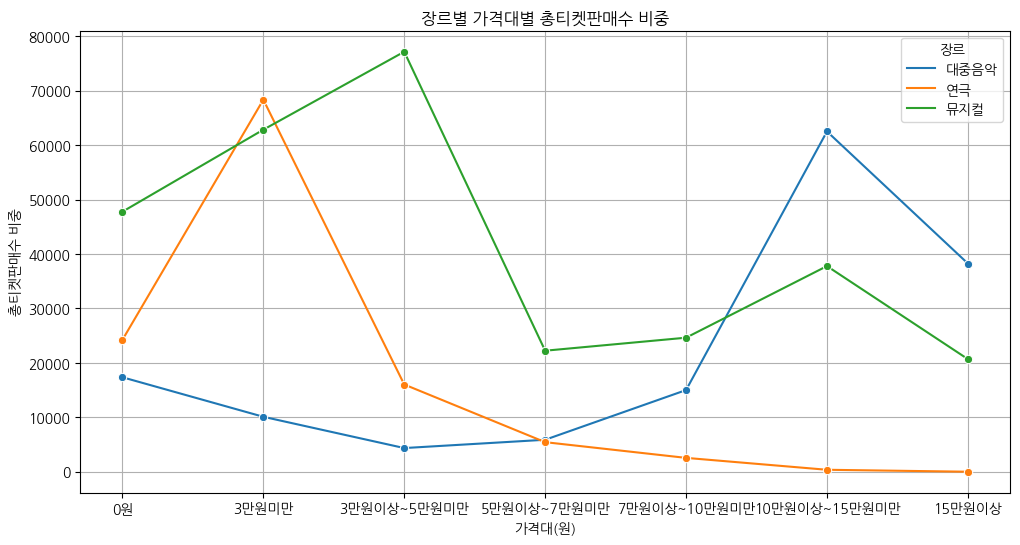

In [ ]:
# 장르별 가격대 예매액(매출) 비중 평균
# 매출 비중 -> 고가 티켓 위 주 공연이 유리
genre_price = price_stats_df.groupby(["장르","가격대"])["총티켓판매수"].mean().reset_index()

genre_price["가격대"] = pd.Categorical(genre_price["가격대"], categories=order, ordered=True)

genre_price = genre_price.sort_values("가격대")

plt.figure(figsize=(12,6))
sns.lineplot(data=genre_price, x="가격대", y="총티켓판매수", hue="장르", marker="o")
plt.title("장르별 가격대별 총티켓판매수 비중")
plt.ylabel("총티켓판매수 비중")
plt.xlabel("가격대(원)")
plt.grid(True)
plt.show()

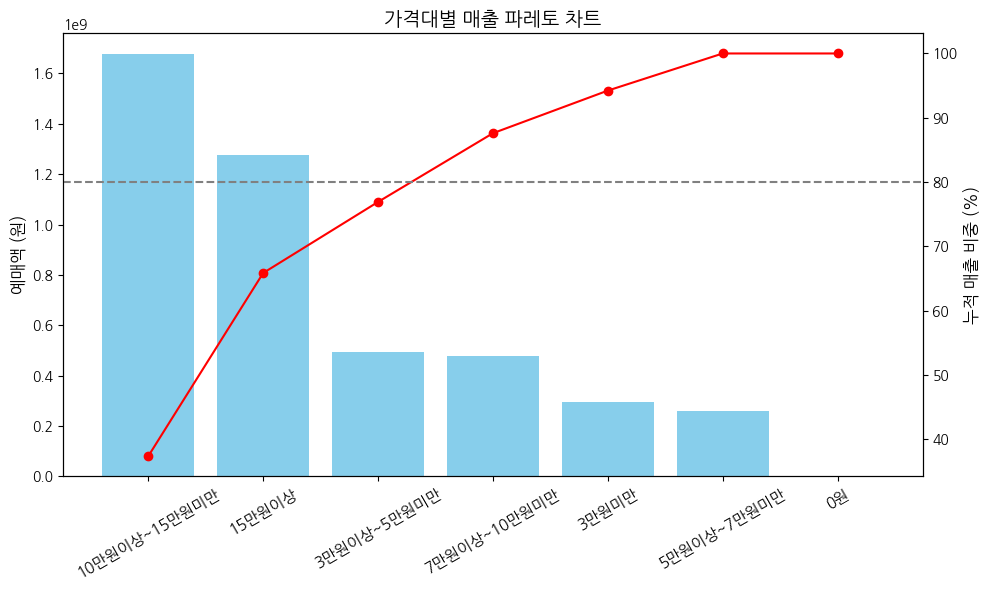

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
d = price_stats_df.copy()
sales_by_price = d.groupby("가격대")["예매액"].sum().reset_index()

# 가격대 정렬 (내림차순 매출 기준)
sales_by_price = sales_by_price.sort_values("예매액", ascending=False)
sales_by_price["누적비중"] = sales_by_price["예매액"].cumsum() / sales_by_price["예매액"].sum() * 100

# 차트 그리기
fig, ax1 = plt.subplots(figsize=(10,6))

# 막대: 매출액
ax1.bar(sales_by_price["가격대"], sales_by_price["예매액"], color="skyblue")
ax1.set_ylabel("예매액 (원)", fontsize=12)

# 선: 누적 비중
ax2 = ax1.twinx()
ax2.plot(sales_by_price["가격대"], sales_by_price["누적비중"], color="red", marker="o", linestyle="-")
ax2.set_ylabel("누적 매출 비중 (%)", fontsize=12)
ax2.axhline(80, color="gray", linestyle="--")  # 80% 기준선

# 제목 & 레이아웃
plt.title("가격대별 매출 파레토 차트", fontsize=14)
ax1.set_xticks(range(len(sales_by_price["가격대"])))
ax1.set_xticklabels(sales_by_price["가격대"], rotation=30, fontsize=11)
plt.tight_layout()
plt.show()
